


### **Datasets**
This is our dataset for this expriment: https://www.kaggle.com/competitions/aptos2019-blindness-detection/data

\
### Alternative datasets:

Kaggle DR competition dataset: [https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data](https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data)



The Indian Diabetic Retinopathy Image Dataset (IDRiD): https://idrid.grand-challenge.org/](https://idrid.grand-challenge.org/)

\
### More on the IDRiD dataset:

 [https://biomedicalimaging.org/2018/challenges/](https://biomedicalimaging.org/2018/challenges/)

 [https://www.mdpi.com/2306-5729/3/3/25#:~:text=To%20the%20best%20of%20our,annotated%20at%20a%20pixel%20level.](https://www.mdpi.com/2306-5729/3/3/25#:~:text=To%20the%20best%20of%20our,annotated%20at%20a%20pixel%20level.)






In [5]:
# !gdown 1pRGDMCSAfjP6vVQxQDy8DL5-QdZ6tBoV
# !unzip -q resized_dataset.zip

import os
from tqdm import tqdm

file_id = '1pRGDMCSAfjP6vVQxQDy8DL5-QdZ6tBoV'
output = 'resized_dataset.zip'

# Check if the file already downloaded
if not os.path.exists(output):
    # Downloading the file
    !gdown --id {file_id} --output {output}
else:
    print(f"'{output}' already exists, skipping download.")

# Unzip the file if it hasn't unzipped yet
if not os.path.exists('resized_dataset'):
    print("Unzipping dataset...")
    !unzip -q {output}
else:
    print("Dataset is already unzipped.")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pRGDMCSAfjP6vVQxQDy8DL5-QdZ6tBoV
From (redirected): https://drive.google.com/uc?id=1pRGDMCSAfjP6vVQxQDy8DL5-QdZ6tBoV&confirm=t&uuid=e680ca6b-0daf-48ff-88ff-5dc201fcded0
To: /content/resized_dataset.zip
100% 574M/574M [00:10<00:00, 52.5MB/s]
Unzipping dataset...


In [6]:
# !mv /content/resized_dataset/content/aptos2019-blindness-detection
# !rm /content/resized_dataset.zip

import shutil

source_path = '/content/resized_dataset'
target_path = '/content/aptos2019-blindness-detection'
zip_file = '/content/resized_dataset.zip'

# Move the directory if it exists
if os.path.exists(source_path):
    print(f"Moving '{source_path}' to '{target_path}'")
    shutil.move(source_path, target_path)
else:
    print(f"Source directory '{source_path}' not fount. Skipping move.")

# Remove the zip file if exists
if os.path.exists(zip_file):
    print(f"Removing '{zip_file}'...")
    os.remove(zip_file)
else:
    print(f"zip file '{zip_file}' not fount. Skipping Removal.")

Moving '/content/resized_dataset' to '/content/aptos2019-blindness-detection'
Removing '/content/resized_dataset.zip'...


## Imports and Random Seeds

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.utils import plot_model


# Set random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# Enable mixed precision to speed up training
set_global_policy('mixed_float16')

 ## Import InceptionV3 from keras and fine tune on retinopathy dataset


 The script below is a very simple example, use the following resources in order to take inspiration for improvements:  https://gist.github.com/didacroyo/839bd1dbb67463df8ba8fb14eb3fde0c    https://gist.github.com/ceceshao1/cb834ed819628244093a2b61408c86e0

\
 ### The script below:

Loads the diabetic_retinopathy_detection dataset from TensorFlow Datasets, dividing it into training and validation sets.

Defines a preprocessing function that normalizes the images to the range [0, 1] and resizes them to the size expected by InceptionV3.

Prepares the training and validation datasets by applying the preprocessing function, shuffling and batching the training data, and batching the validation data.

Loads the InceptionV3 model, excluding its top (classification) layers.
Freezes the base InceptionV3 model, so that its weights won't be updated during training.

Adds a new classification head to the model, consisting of a global average pooling layer and a dense layer with a softmax activation function.

Trains the model on the training data.





In [8]:
# Load the CSV files containing the labels
def load_csv_file(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None


train_df = load_csv_file('aptos2019-blindness-detection/train.csv')
test_df = load_csv_file('aptos2019-blindness-detection/test.csv')
labels_df = load_csv_file('aptos2019-blindness-detection/sample_submission.csv')

In [9]:
def append_png(df, column_name='id_code'):
    df[column_name] = df[column_name].astype(str) + '.png'
    return df


train_df = append_png(train_df)
test_df = append_png(test_df)
labels_df = append_png(labels_df)

In [10]:
print(train_df.head())

            id_code  diagnosis
0  000c1434d8d7.png          2
1  001639a390f0.png          4
2  0024cdab0c1e.png          1
3  002c21358ce6.png          0
4  005b95c28852.png          0


### Plotting a Sample of Images from the Dataset


<function matplotlib.pyplot.show(close=None, block=None)>

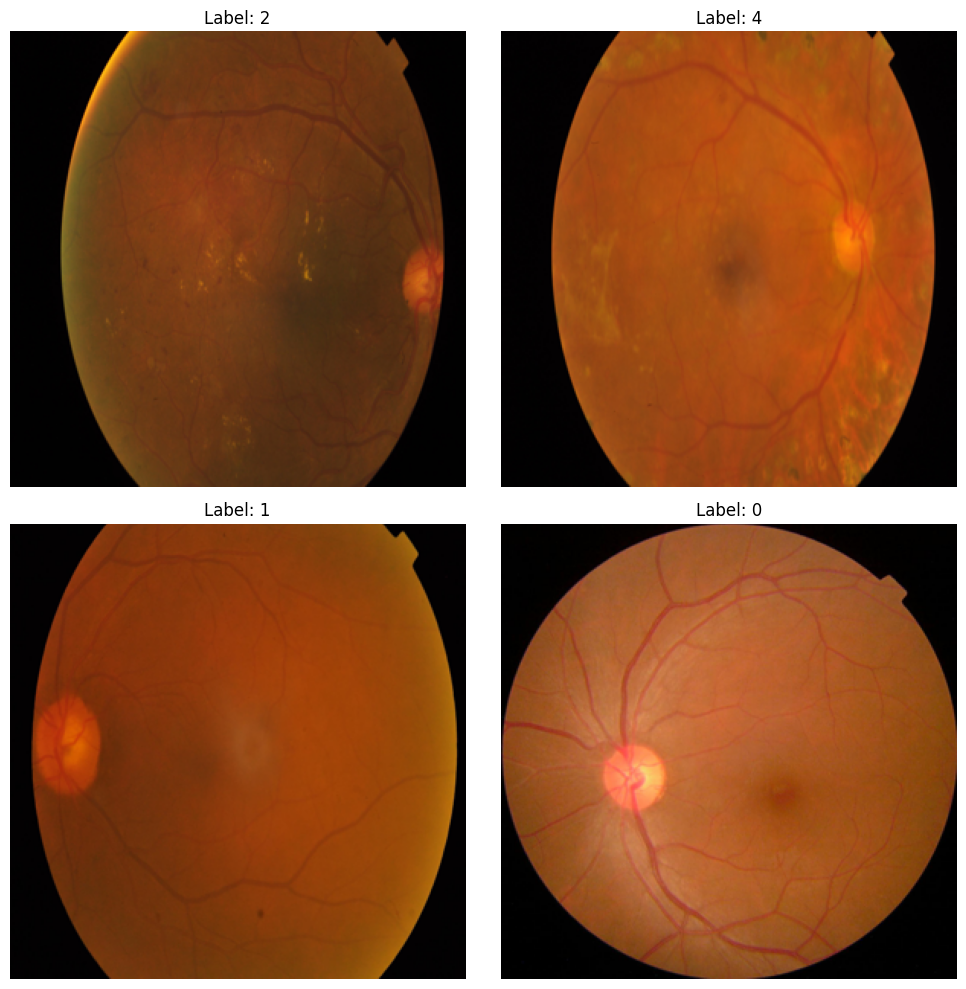

In [11]:
# Define a path for images
image_path = '/content/aptos2019-blindness-detection/train_images/'

#Select the first four images to visualize
first_four = train_df.head(4)

# Create a 2x2 grid of subplots for visualization
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, row in first_four.iterrows():
    img_path = row['id_code']

    try:
        # Read the image from the local file
        img = mpimg.imread(os.path.join(image_path, img_path))

        # Plot the image in the corresponding subplot
        axs[i // 2, i % 2].imshow(img)
        axs[i // 2, i % 2].axis('off')
        axs[i // 2, i % 2].set_title(f"Label: {row['diagnosis']}")

    except FileNotFoundError:
        print(f"Image {img_path} not found. Skipping.")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show

### Plotting the InceptionV3 Model Architecture

Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for GoogLeNet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge.

resources:

[Google: https://cloud.google.com/tpu/docs/inception-v3-advanced](https://cloud.google.com/tpu/docs/inception-v3-advanced)

\
Loads the InceptionV3 model pre-trained on ImageNet, excluding the top layers (include_top=False). This allows us to use it as a feature extractor without the final classification layers, so we can add our own custom layers for the specific task at hand (e.g., diabetic retinopathy classification).

In [12]:
# Load the InceptionV3 model pre-trained on ImageNet, excluding the top layers.
base_model = InceptionV3(weights='imagenet', include_top=False)

# Conditional model plotting (to avoid redundant operations)
plot_model_enabled = True
if plot_model_enabled:
    """
    Show_shape argument helps in understanding the output dimensions of each layer.
    Use dpi to make the visualization more readable if the graph is large.
    """
    plot_model(base_model, to_file='inception_model.png', show_shapes=True, dpi=150)

# Print the model summary (uncomment if needed)
# print(base_model.summary())

# Print the number of layers in the base model.
print(f"The number of layers in the base InceptionV3 model is: {len(base_model.layers)}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.836063 to fit

The number of layers in the base InceptionV3 model is: 311


## Preparing the data for training

Here we are using Keras' ImageDataGenerator, which is a convenient way to load and preprocess image data on-the-fly during training (directly from files).

\
**Training Generator** (train_generator): Loads and generates batches of images for training, using 80% of the data.

**Validation Generator** (validation_generator): Loads and generates batches of images for validation, using 20% of the data.

In [13]:
# Create ImageDataGenerators for Training Data (with Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    validation_split=0.2,      # Reserve 20% of the training data for validation
    rotation_range=20,         # Randomly rotate images in the range of 0-20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    horizontal_flip=True,      # Randomly flip images horizontally
    zoom_range=0.2             # Random zoom
)

# Create ImageDataGenerator for Validation Data (No Augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    validation_split=0.2    # Use the same split as for training data
)

# Create Training Data Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',    # Path to the image directory
    x_col='id_code',           # Column in DataFrame that contains the image filenames
    y_col='diagnosis',         # Column in DataFrame that contains the labels
    target_size=(299, 299),    # Resize images to the target size (299x299) for InceptionV3
    batch_size=32,             # Number of images per batch
    subset='training',         # Use the 'training' subset (80% of data)
    class_mode='raw',          #  Output labels as raw numerical values
    shuffle=True,              # Shuffle the images at the beginning of each epoch
    seed=123                   # Random seed for shuffling to ensure reproducibility
)

# Create Validation Data Generator
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',    # Path to the image directory
    x_col='id_code',           # Column in DataFrame that contains the image filenames
    y_col='diagnosis',         # Column in DataFrame that contains the labels
    target_size=(299, 299),    # Resize images to the target size (299x299) for InceptionV3
    batch_size=32,             # Number of images per batch
    subset='validation',       # Use the 'validation' subset (20% of data)
    class_mode='raw',          # Output labels as raw numerical values
    shuffle=False,             # No need to shuffle validation data
    seed=123                   # Random seed for consistency
)

Found 2930 validated image filenames.
Found 732 validated image filenames.


In [14]:
def inception_operation(inputs: tf.Tensor, base_model: tf.keras.Model, training: bool = False) -> tf.Tensor:
    """
    Apply the base model (e.g., InceptionV3) to the input tensor. Change it to a preferred model.
    training argument. This allows the function to adjust its behavior based on whether it's called during feature extraction (training=False) or during fine-tuning (training=True).

    Parameters:
    inputs (tf.Tensor): The input tensor or batch of image data.
    base_model (tf.keras.Model): The pre-trained base model without the top layers.
    training (bool): If True, run the model in training mode (useful for fine-tuning).

    Returns:
    tf.Tensor: The output tensor after applying the base model.
    """

    return base_model(inputs, training=training)

## Adapting to Specific Number of Output Classes

The pre-trained InceptionV3 model is trained on **ImageNet**, which has **1,000 classes**. However, for **diabetic retinopathy detection** (like the APTOS dataset), we need **5 output classes** representing different levels of severity of retinopathy, ranging from no retinopathy to proliferative retinopathy.

### Custom Output Layer
By adding a new **Dense layer** with **5 units** and **softmax activation**, we adjust the model to produce predictions specifically for the number of classes in our dataset.

### Custom Layers Serve Several Purposes:

1. **Adjust for Specific Classes**: Convert the generic features learned by InceptionV3 into task-specific predictions by adding a final Dense layer with the correct number of output units.

2. **Task-Specific Learning**: Enhance the base model’s extracted features using additional layers like **Dense** and **Global Average Pooling**.

3. **Prevent Overfitting**: Use layers like **Dropout** to regularize and improve generalization, especially when fine-tuning with smaller datasets.

4. **Non-linearity**: Add complexity with **Dense layers** to learn non-linear relationships between features.

5. **Global Feature Aggregation**: Use **GlobalAveragePooling2D** to summarize the extracted feature maps into a more compact form.

In short, adding custom layers allows you to **bridge the gap** between the pre-trained feature extractor (InceptionV3) and the specific requirements of the diabetic retinopathy detection task. Without these custom layers, the model would not be able to make **accurate predictions** that are tailored to the problem domain.

### Summary of the code below:

The model training process uses **transfer learning** to leverage a pre-trained InceptionV3 model.

**Two-phase Training**:
1. **Initial Phase**: Freeze the base model and train only custom layers.
2. **Fine-Tuning Phase**: Unfreeze specific layers of the base model to fine-tune it for the task.

### Key Optimizations and Features:

- **Callbacks (EarlyStopping and ReduceLROnPlateau)**: Used to improve the model's training process, prevent overfitting, and ensure better convergence.
- **Mixed Precision Training**: Enabled for faster training on modern GPUs.
- **Enhanced Data Augmentation**: Added zoom augmentation to the training data generator.
- **Gradient Clipping**: Added to the Adam optimizer to prevent exploding gradients.
- **Model Checkpointing**: Added to save the best-performing model based on validation accuracy.

### Fine-Tuning Adjustments:
- **Dynamic Layer Selection**: Fine-tuning starts from **layer 200**.
- **Batch Normalization Freezing**: BatchNormalization layers are kept frozen during fine-tuning for stability.

### Callbacks for Monitoring and Optimization:
- **Added TensorBoard** for detailed training visualization.
- **Increased Patience** in EarlyStopping for more stable convergence.

### Refactored Training Function:
- **Added Flexibility** by allowing custom optimizers and callbacks to be passed as parameters.
- **Best Model Recovery**: The model checkpointing ensures that you can recover the model at its **best state**, even if training leads to overfitting afterward.


In [15]:
def train_inception(
    train_processed,
    validation_processed,
    base_model, # Use the already loaded base_model
    first_layer_operation=inception_operation,
    epochs_initial=20,
    epochs_fine=10,
    fine_tune_at=200, # Start fine-tuning from a higher layer to ensure stability
    learning_rate=1e-4,
    dropout_rate=0.5,
    optimizer=None,
    callbacks=None):
    """
    Train the InceptionV3 model using the given datasets.

    Parameters:
    train_processed (tf.data.Dataset): The processed training dataset.
    validation_processed (tf.data.Dataset): The processed validation dataset.
    base_model (tf.keras.Model): The pre-trained InceptionV3 base model without the top layers.
    first_layer_operation (function): Function to apply to the input and base model.
    epochs_initial (int): Number of epochs for initial training with frozen base model.
    epochs_fine (int): Number of epochs for fine-tuning the model.
    fine_tune_at (int): Layer number from which to start fine-tuning.
    learning_rate (float): Learning rate for training.
    dropout_rate (float): Dropout rate for the dense layer.
    optimizer (tf.keras.optimizers.Optimizer): Optimizer to use for training.
    callbacks (list): List of callback functions to use during training.

    Returns:
    tf.keras.Model: The trained model.
    History: Training history for the initial training phase.
    History: Training history for the fine-tuning phase.
    """

    # Freeze the base mdoel layers
    base_model.trainable = False

    # Define input tensor
    inputs = tf.keras.Input(shape=(299, 299, 3))

    # Intial feature extraction phase
    x = first_layer_operation(inputs, base_model, training=False)

    # Add cutom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # 5 classes in APTOS dataset
    outputs = Dense(5, activation='softmax', dtype='float32')(x) # Use float32 for output to match mixed precision requirements
    model = Model(inputs, outputs)

    # Complie the model for initil training
    if optimizer is None:
      optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0) # Default optimizer with gradient clipping

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    # Initial training
    history_initial = model.fit(
        train_processed,
        validation_data=validation_processed,
        epochs=epochs_initial,
        callbacks=callbacks,
        verbose=1 # Add verbose parameter to control the verbosity of the training process.
    )

    # Fine-tuning the model from `fine_tune_at` layer onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False    # Keep BatchNormalization layers frozen for stability

    # Compile the model for fine-tuning
    model.Compile(
        optimizer=Adam(learning_rate=learning_rate / 10, clipnorm=1.0), # Lower learning rate for fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning Training
    history_fine = model.fit(
        train_processed,
        validation_data=validation_processed,
        epochs=epochs_fine,
        callbacks=callbacks,
        verbose=1
    )

    return model, history_initial, history_fine

##Plotting Model Accuracy

In [12]:
def plot_history(history_initial, history_fine):
    """
    Plots the training and validation accuracy and loss over the epochs for both the initial training
    and fine-tuning phases.

    Parameters:
    history_initial (History): History object from the initial training phase.
    history_fine (History): History object from the fine-tuning phase.
    """
    # Concatenate histories for initial and fine-tuning phases
    accuracy = history_initial.history.get('accuracy', []) + history_fine.history.get('accuracy', [])
    val_accuracy = history_initial.history.get('val_accuracy', []) + history_fine.history.get('val_accuracy', [])
    loss = history_initial.history.get('loss', []) + history_fine.history.get('loss', [])
    val_loss = history_initial.history.get('val_loss', []) + history_fine.history.get('val_loss', [])

    # Summarize history for accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Train - Initial + Fine-Tuning', color='b', linestyle='-')
    plt.plot(val_accuracy, label='Validation - Initial + Fine-Tuning', color='r', linestyle='-')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.length(loc='upper left')
    plt.grid(True)

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train - Initial + Fine-Tuning', color='b', linestyle='-')
    plt.plot(val_loss, label='Validation - Initial + Fine-Tuning', color='r', linestyle='-')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.length(loc='upper left')
    plt.grid(True)

    # To ensure the subplots do not overlap
    plt.tight_layout()
    plt.show()

## Train the InceptionV3 model

**The train_inception()** function performs two phases of training:

\
**Initial Training Phase**: The base model (InceptionV3) is frozen and only the custom layers are trained. This helps adapt the model to the new data while keeping the general features learned from ImageNet intact.

**Fine-Tuning Phase**: After the initial training, part of the base model is unfrozen and fine-tuned. This allows some layers in the base model to adapt more closely to the specific features of diabetic retinopathy.

\
**Returned Outputs**:

**model**: The fully trained model after both the initial training and fine-tuning phases.

**history_i**: The training history from the initial training phase (with the base model frozen). Contains metrics such as loss and accuracy for each epoch during the initial training phase.

**history_f**: The training history from the fine-tuning phase. Contains metrics such as loss and accuracy for each epoch during fine-tuning, reflecting how well the model has improved during fine-tuning.

In [ ]:


    """
    EarlyStopping: This callback is used to stop training when the monitored metric (e.g., validation loss)
                  has stopped improving, thereby avoiding overfitting and reducing training time.

    ReduceLROnPlateau: This callback is used to reduce the learning rate when a monitored metric has stopped
                      improving, which helps the model converge better during training.

    BatchNormalization: This layer normalizes the activations of the previous layer to improve training stability,
                        speed up convergence, and reduce sensitivity to weight initialization.
    """
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_schedualer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model, history_i, history_f = train_inception(train_generator, validation_generator)

Epoch 1/20
92/92 [==============================] - 34s 316ms/step - loss: 1.0654 - accuracy: 0.6239 - val_loss: 0.8595 - val_accuracy: 0.7145
Epoch 2/20
92/92 [==============================] - 27s 292ms/step - loss: 0.8072 - accuracy: 0.7109 - val_loss: 0.8155 - val_accuracy: 0.7022
Epoch 3/20
92/92 [==============================] - 25s 266ms/step - loss: 0.7487 - accuracy: 0.7270 - val_loss: 0.7571 - val_accuracy: 0.7295
Epoch 4/20
92/92 [==============================] - 25s 267ms/step - loss: 0.6912 - accuracy: 0.7454 - val_loss: 0.7263 - val_accuracy: 0.7514
Epoch 5/20
92/92 [==============================] - 27s 294ms/step - loss: 0.6607 - accuracy: 0.7590 - val_loss: 0.6817 - val_accuracy: 0.7568
Epoch 6/20
92/92 [==============================] - 28s 300ms/step - loss: 0.6378 - accuracy: 0.7638 - val_loss: 0.6847 - val_accuracy: 0.7500
Epoch 7/20
92/92 [==============================] - 26s 281ms/step - loss: 0.6183 - accuracy: 0.7754 - val_loss: 0.6688 - val_accuracy: 0.7719

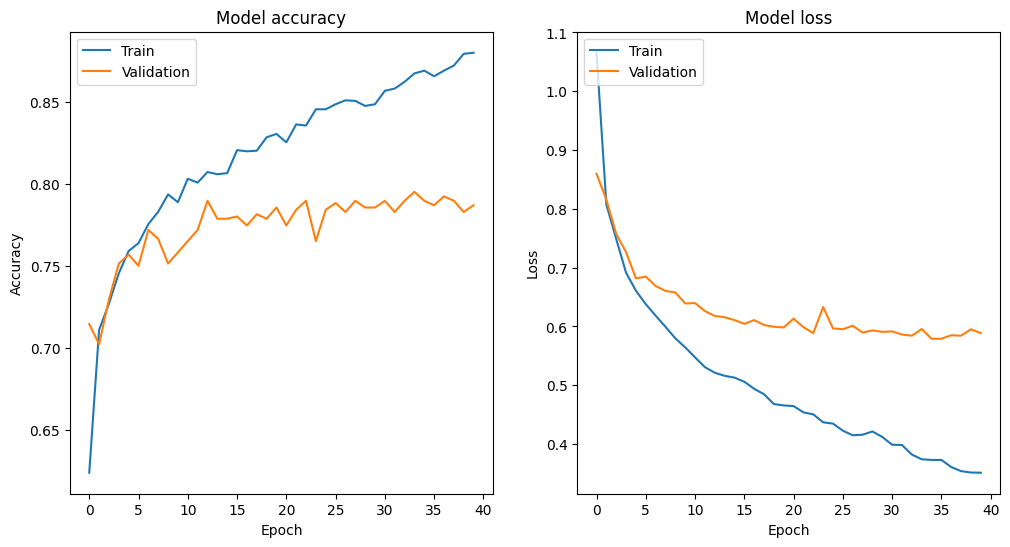

In [ ]:
plot_history(history_i, history_f)

In [ ]:
validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

Found 732 validated image filenames.
23/23 [==============================] - 7s 199ms/step


In [ ]:
from sklearn.metrics import classification_report

# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


                     precision    recall  f1-score   support

           No DR -0       0.97      0.97      0.97       337
            Mild -1       0.72      0.47      0.57        77
        Moderate -2       0.64      0.89      0.75       221
          Severe -3       0.35      0.16      0.22        38
Proliferative DR -4       0.48      0.19      0.27        59

           accuracy                           0.79       732
          macro avg       0.63      0.53      0.55       732
       weighted avg       0.77      0.79      0.76       732



<Axes: >

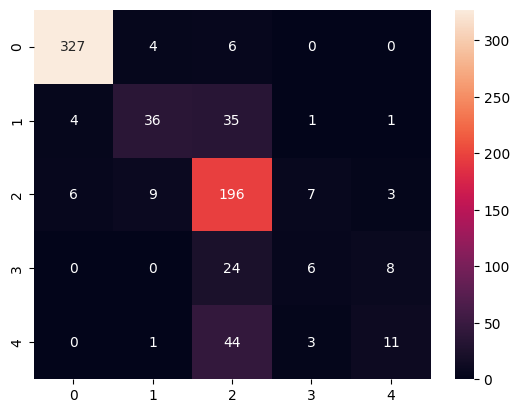

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

## Sorbel edge detector

In [ ]:
import cv2

In [ ]:
def sobel_operation(inputs, base_model):
    x = SobelEdgeDetection()(inputs)
    return base_model(x)

In [ ]:
class SobelEdgeDetection(tf.keras.layers.Layer):
    def __init__(self):
        super(SobelEdgeDetection, self).__init__()
        self.sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)[..., tf.newaxis, tf.newaxis]
        self.sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)[..., tf.newaxis, tf.newaxis]

    def call(self, inputs):
        inputs = tf.image.rgb_to_grayscale(inputs)
        edges_x = tf.nn.conv2d(inputs, self.sobel_x, strides=[1, 1, 1, 1], padding='SAME')
        edges_y = tf.nn.conv2d(inputs, self.sobel_y, strides=[1, 1, 1, 1], padding='SAME')
        edges = tf.sqrt(tf.square(edges_x) + tf.square(edges_y))
        # Stack the grayscale image across the color dimension
        edges = tf.concat([edges, edges, edges], axis=-1)
        return edges


In [ ]:
def sobel_edge_detector(image, ksize=3):
    image = (image * 255).astype(np.uint8)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the Sobel operator in the x and y directions
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=ksize)

    # Combine the x and y gradients
    sobel = np.hypot(sobelx, sobely)

    # Normalize and scale the image
    sobel = np.uint8(sobel / np.max(sobel) * 255)

    # The Sobel function returns a grayscale image, so we need to
    # add two extra dimensions to use it with a Keras model
    sobel = np.stack((sobel,) * 3, axis=-1)
    sobel = sobel / 255.
    return sobel

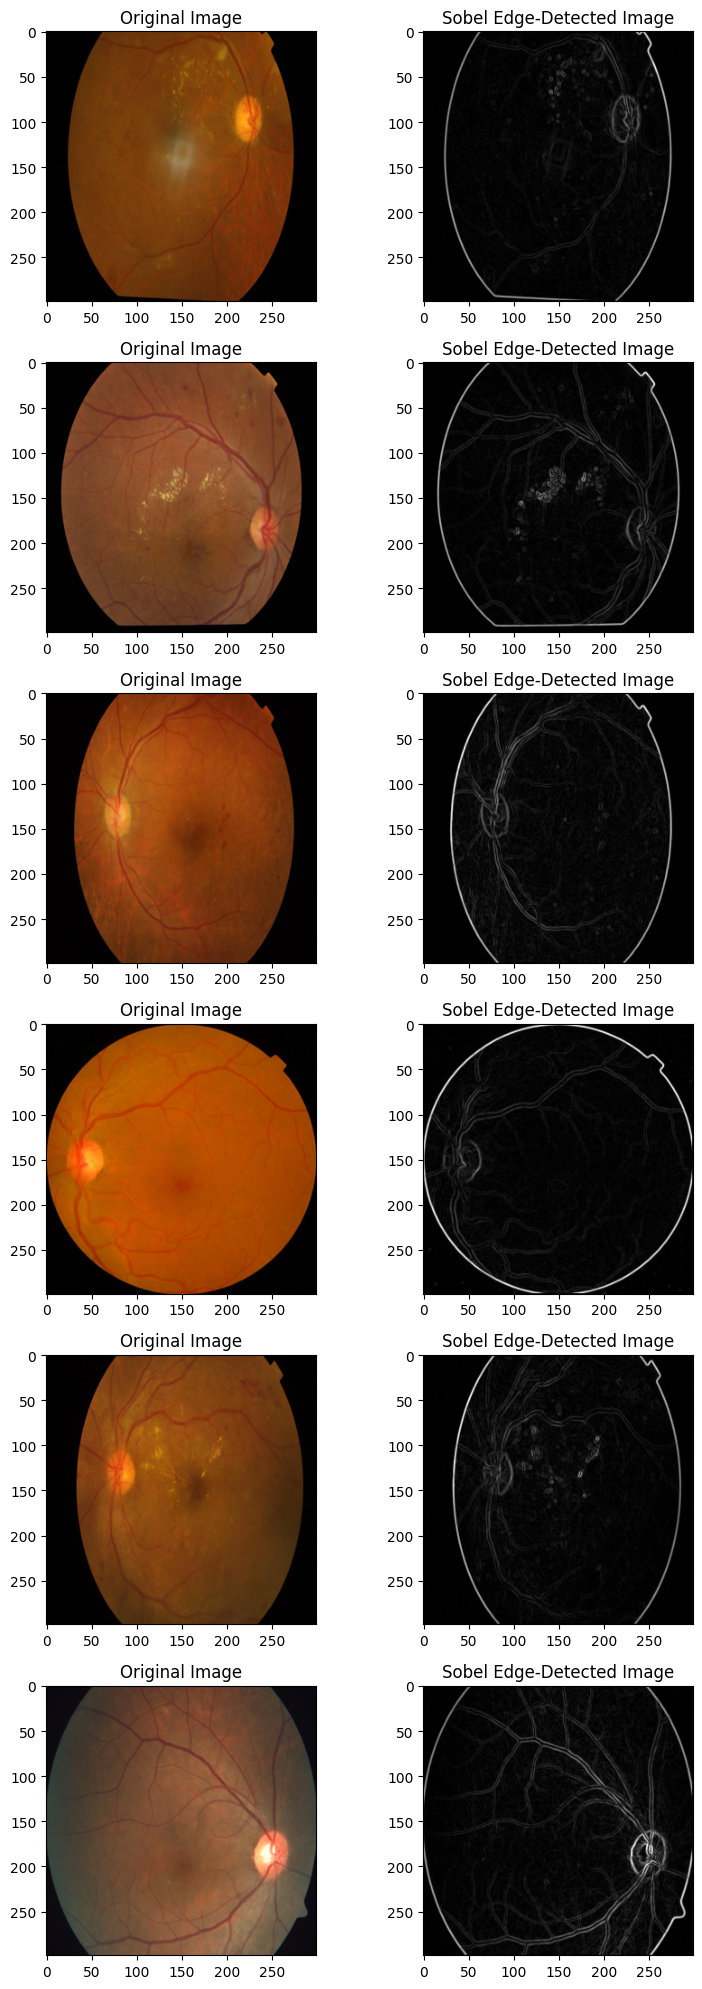

In [ ]:
# Instantiate the edge detection layer
#sobel_layer = SobelEdgeDetection()

# Load some images
images, _ = next(iter(train_generator))

# Apply edge detection
edge_images = [sobel_edge_detector(image) for image in images]

# Visualize the images and their edge-detected counterparts
fig, axs = plt.subplots(6, 2, figsize=(8, 20))

for i in range(6):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(edge_images[i])
    axs[i, 1].set_title('Sobel Edge-Detected Image')

plt.tight_layout()
plt.show()

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=sobel_edge_detector)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

Found 2930 validated image filenames.
Found 732 validated image filenames.


In [ ]:
# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_inception(train_generator, validation_generator)

Epoch 1/20
92/92 [==============================] - 44s 432ms/step - loss: 1.3260 - accuracy: 0.4805 - val_loss: 1.2799 - val_accuracy: 0.4604
Epoch 2/20
92/92 [==============================] - 46s 503ms/step - loss: 1.2719 - accuracy: 0.5010 - val_loss: 1.2601 - val_accuracy: 0.4604
Epoch 3/20
92/92 [==============================] - 36s 387ms/step - loss: 1.2241 - accuracy: 0.5212 - val_loss: 1.2050 - val_accuracy: 0.4604
Epoch 4/20
92/92 [==============================] - 36s 386ms/step - loss: 1.1839 - accuracy: 0.5317 - val_loss: 1.1863 - val_accuracy: 0.4604
Epoch 5/20
92/92 [==============================] - 39s 427ms/step - loss: 1.1607 - accuracy: 0.5410 - val_loss: 1.1507 - val_accuracy: 0.4809
Epoch 6/20
92/92 [==============================] - 37s 406ms/step - loss: 1.1201 - accuracy: 0.5717 - val_loss: 1.1315 - val_accuracy: 0.4604
Epoch 7/20
92/92 [==============================] - 36s 389ms/step - loss: 1.1020 - accuracy: 0.5775 - val_loss: 1.1018 - val_accuracy: 0.5055

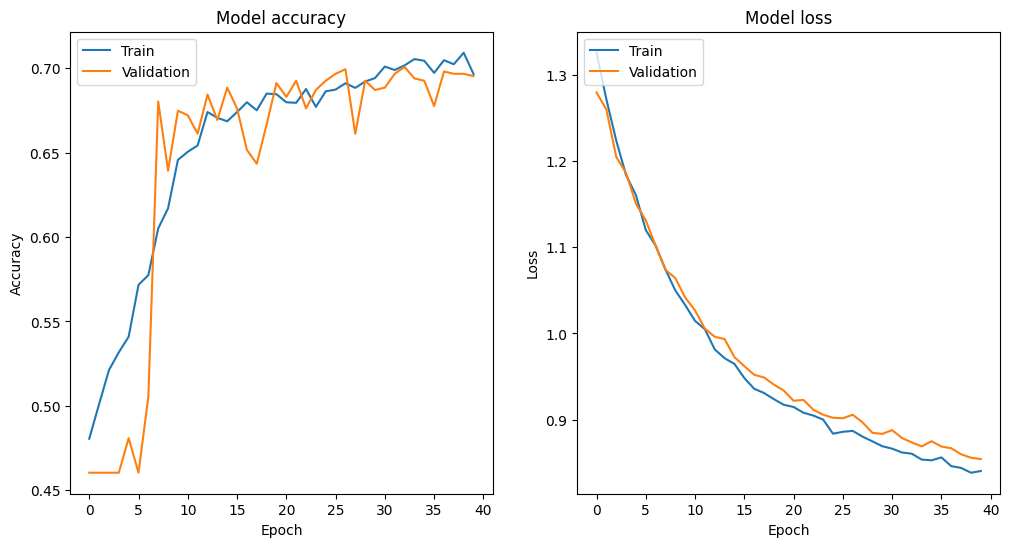

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

Found 732 validated image filenames.
23/23 [==============================] - 8s 314ms/step


In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


                     precision    recall  f1-score   support

           No DR -0       0.88      0.93      0.90       337
            Mild -1       0.00      0.00      0.00        77
        Moderate -2       0.52      0.89      0.66       221
          Severe -3       0.00      0.00      0.00        38
Proliferative DR -4       0.00      0.00      0.00        59

           accuracy                           0.70       732
          macro avg       0.28      0.36      0.31       732
       weighted avg       0.56      0.70      0.61       732



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

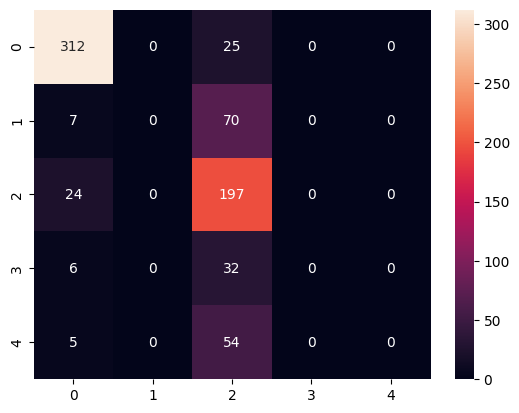

In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

## HYBRID Sobel
Test with using both original images and Sorbel modified images:

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

Found 2930 validated image filenames.
Found 732 validated image filenames.


In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen_sobel = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=sobel_edge_detector)

train_generator_sobel = train_datagen_sobel.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator_sobel = train_datagen_sobel.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

Found 2930 validated image filenames.
Found 732 validated image filenames.


In [ ]:
def combined_generator(gen1, gen2):
    while True:
        yield next(gen1)
        yield next(gen2)

train_combined = combined_generator(train_generator, train_generator_sobel)
validation_combined = combined_generator(validation_generator, validation_generator_sobel)

steps_per_epoch = len(train_generator) + len(train_generator_sobel)
validation_steps = len(validation_generator) + len(validation_generator_sobel)

In [ ]:
def train_sobel(train_processed, validation_processed, steps_per_epoch, validation_steps):
    # Load the InceptionV3 model and exclude the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Freeze the base_model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))

    # Use the first_layer_operation
    x = inception_operation(inputs, base_model)

    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(5, activation='softmax')(x)  # 5 classes in APTOS dataset
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(5e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_initial = model.fit(train_processed, validation_data=validation_processed, steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, epochs=20)

    # Fine-tune from this layer onwards
    fine_tune_at = 155

    # Unfreeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(optimizer=Adam(5e-5),  # Lower learning rate
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tuning
    history_fine = model.fit(train_processed, validation_data=validation_processed, steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, epochs=20)

    return model, history_initial, history_fine

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_sobel(train_combined, validation_combined, steps_per_epoch, validation_steps)

Epoch 1/20
184/184 [==============================] - 76s 392ms/step - loss: 1.1856 - accuracy: 0.5602 - val_loss: 1.0621 - val_accuracy: 0.5840
Epoch 2/20
184/184 [==============================] - 69s 374ms/step - loss: 1.0442 - accuracy: 0.6022 - val_loss: 1.0249 - val_accuracy: 0.5936
Epoch 3/20
184/184 [==============================] - 69s 374ms/step - loss: 0.9878 - accuracy: 0.6254 - val_loss: 0.9842 - val_accuracy: 0.5895
Epoch 4/20
184/184 [==============================] - 68s 372ms/step - loss: 0.9545 - accuracy: 0.6343 - val_loss: 0.9781 - val_accuracy: 0.6066
Epoch 5/20
184/184 [==============================] - 69s 374ms/step - loss: 0.9201 - accuracy: 0.6449 - val_loss: 0.9181 - val_accuracy: 0.6264
Epoch 6/20
184/184 [==============================] - 68s 372ms/step - loss: 0.8973 - accuracy: 0.6558 - val_loss: 0.9144 - val_accuracy: 0.6148
Epoch 7/20
184/184 [==============================] - 68s 370ms/step - loss: 0.8769 - accuracy: 0.6548 - val_loss: 0.8967 - val_ac

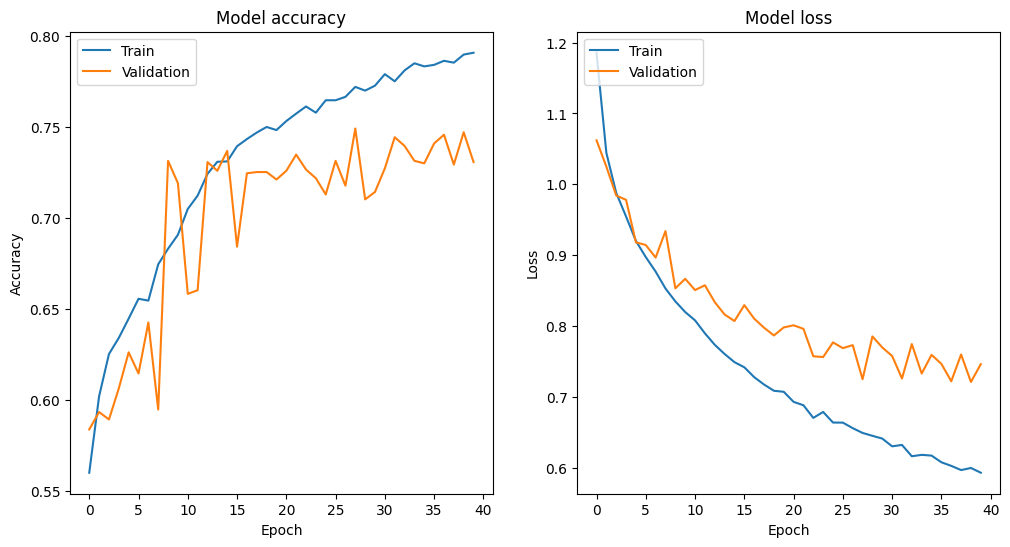

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

Found 732 validated image filenames.
23/23 [==============================] - 6s 197ms/step


In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


                     precision    recall  f1-score   support

           No DR -0       0.94      0.98      0.96       337
            Mild -1       0.74      0.48      0.58        77
        Moderate -2       0.66      0.84      0.74       221
          Severe -3       0.32      0.16      0.21        38
Proliferative DR -4       0.47      0.27      0.34        59

           accuracy                           0.78       732
          macro avg       0.63      0.55      0.57       732
       weighted avg       0.77      0.78      0.77       732



<Axes: >

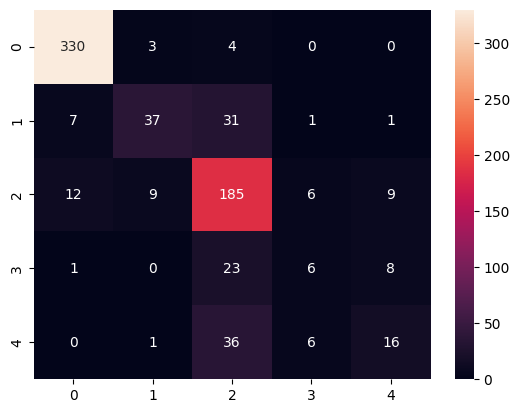

In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

# Canny edge detector

In [ ]:
import cv2

In [ ]:
'''
 thresholds control the edge detection process: edges with a gradient value below threshold1 are discarded,
 and edges with a gradient above threshold2 are marked as "strong" edges.
 Edges with gradients between threshold1 and threshold2 are marked as "weak" edges,
 and are only kept in the final edge map if they're connected to strong edges.
'''

def canny_edge_detector(image):
    # Convert the image to uint8 format suitable for Canny
    image = (image * 255).astype(np.uint8)
    # convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # perform the canny edge detector to detect image edges
    edges = cv2.Canny(grayscale_image, threshold1=0.1, threshold2=20) # default was 100 and 200
    # stack the edge image to 3-channel
    edges = np.stack((edges, edges, edges), axis=-1)
    # rescale pixel values to be between 0 and 1
    edges = edges / 255.
    return edges

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=canny_edge_detector)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

Found 2930 validated image filenames.
Found 732 validated image filenames.


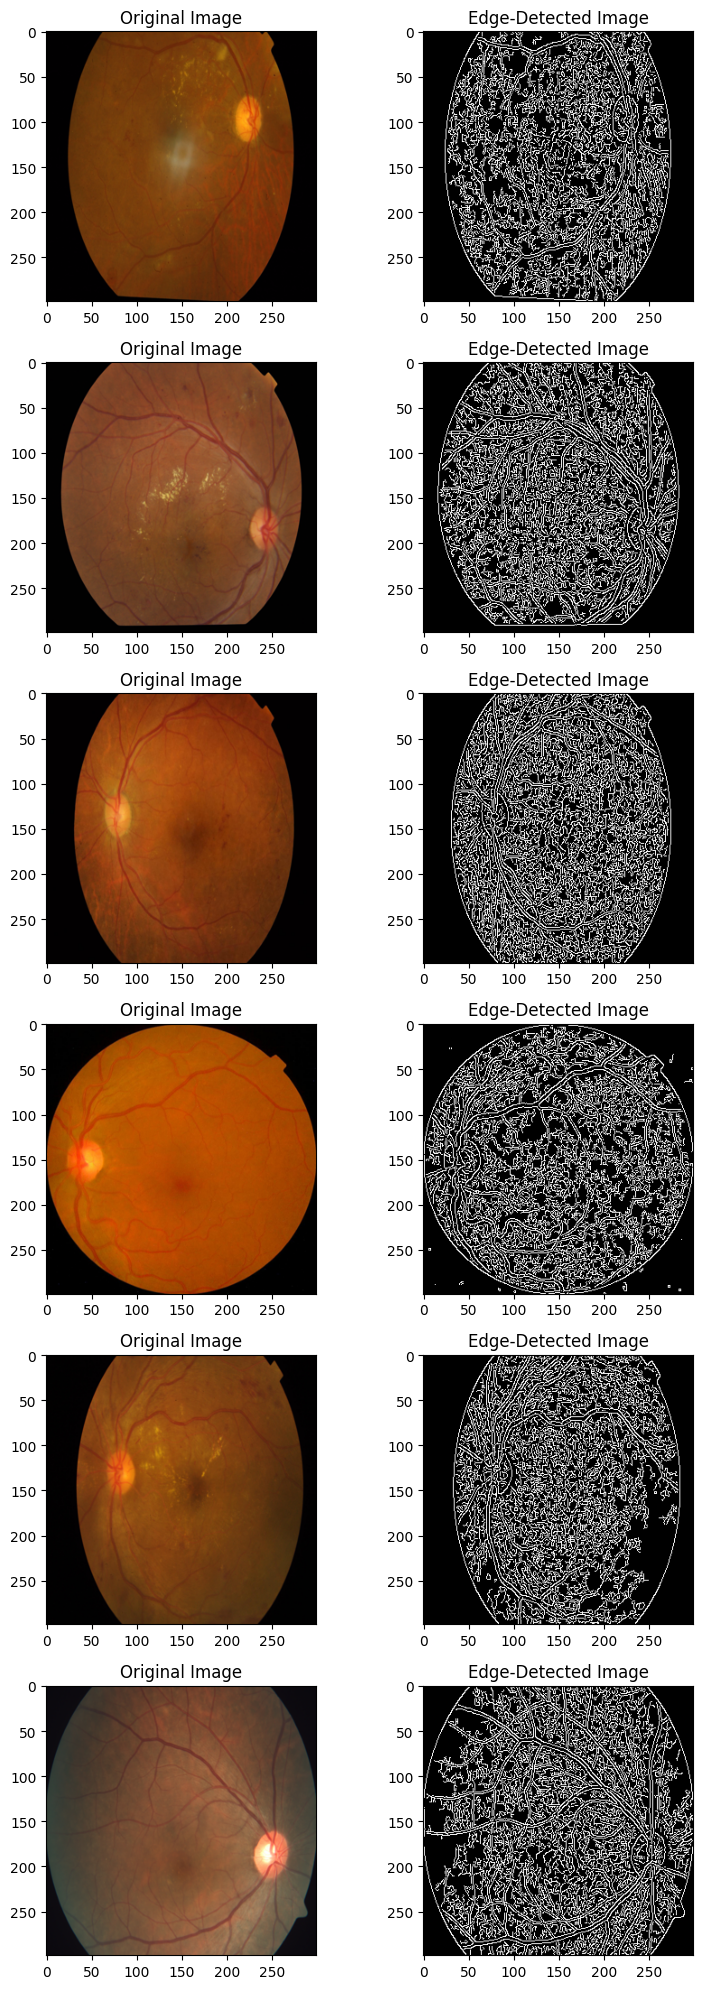

In [ ]:
# Load some images
edge_images = np.array([canny_edge_detector(image) for image in images])

# Visualize the images and their edge-detected counterparts
fig, axs = plt.subplots(6, 2, figsize=(8, 20))

for i in range(6):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(edge_images[i])
    axs[i, 1].set_title('Edge-Detected Image')

plt.tight_layout()
plt.show()

In [ ]:
# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_inception(train_generator, validation_generator)

Epoch 1/20
92/92 [==============================] - 38s 369ms/step - loss: 1.3358 - accuracy: 0.4642 - val_loss: 1.2625 - val_accuracy: 0.5014
Epoch 2/20
92/92 [==============================] - 34s 370ms/step - loss: 1.2491 - accuracy: 0.5235 - val_loss: 1.2247 - val_accuracy: 0.5464
Epoch 3/20
92/92 [==============================] - 32s 346ms/step - loss: 1.2168 - accuracy: 0.5386 - val_loss: 1.2202 - val_accuracy: 0.4836
Epoch 4/20
92/92 [==============================] - 32s 352ms/step - loss: 1.1687 - accuracy: 0.5611 - val_loss: 1.1759 - val_accuracy: 0.5273
Epoch 5/20
92/92 [==============================] - 33s 361ms/step - loss: 1.1541 - accuracy: 0.5700 - val_loss: 1.1464 - val_accuracy: 0.5587
Epoch 6/20
92/92 [==============================] - 33s 357ms/step - loss: 1.1290 - accuracy: 0.5710 - val_loss: 1.1371 - val_accuracy: 0.5451
Epoch 7/20
92/92 [==============================] - 33s 353ms/step - loss: 1.1160 - accuracy: 0.5894 - val_loss: 1.1183 - val_accuracy: 0.5628

KeyboardInterrupt: ignored

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

# Gaussian blur

We will now apply gaussian blur which removes edges.

In [ ]:
def gaussian_blur(image):
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (9, 9), 0)
    return blurred_image

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=gaussian_blur)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

In [ ]:
# Load some images
blurred_images = np.array([gaussian_blur(image) for image in images])

# Visualize the images and their edge-detected counterparts
fig, axs = plt.subplots(6, 2, figsize=(8, 20))

for i in range(6):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(blurred_images[i])
    axs[i, 1].set_title('Gaussian Blur Image')

plt.tight_layout()
plt.show()

In [ ]:
# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_inception(train_generator, validation_generator)

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

## Contrast
Let's try to increase contrast

In [ ]:
'''
The parameters clipLimit and tileGridSize need to be adjusted depending on your specific use case.
The clipLimit parameter limits the amplification of contrast to prevent over-amplification of noise,
and the tileGridSize parameter specifies the size of the grid for the adaptive histogram equalization.
Smaller grid sizes will adapt to smaller changes in contrast, but may result in a more noisy appearance.
'''
def CLAHE_contrast(image, clip_limit, tile_grid_size):
    # Convert the image to uint8 format suitable for CLAHE
    image = (image * 255).astype(np.uint8)
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # rescale pixel values to be between 0 and 1
    enhanced_img = enhanced_img / 255.

    return enhanced_img
'''
cv2.split(yCrCb) is used to separate the Y, Cr, and Cb channels of the image.
The CLAHE is applied only to the Y channel, which represents luminance.
The processed Y channel is then merged back with the original Cr and Cb channels using cv2.merge([clahe_Y, Cr, Cb]).
The resulting image is converted back to the BGR color space before saving.
'''

In [ ]:
import itertools

# Define the range of parameters you want to try
clip_limits = np.linspace(1.0, 10.0, 5)  # 5 values from 1.0 to 10.0
tile_grid_sizes = [(i, i) for i in range(2, 6)]  # four sizes: (2,2), (3,3), (4,4), (5,5)

# Create all combinations of parameters
parameters = list(itertools.product(clip_limits, tile_grid_sizes))

# Load one image
image = images[1]  # or choose any image you like
# Create a figure to hold the subplots
fig = plt.figure(figsize=(20, 20))

# Add original image subplot
ax1 = fig.add_subplot(len(clip_limits) + 1, len(tile_grid_sizes) + 1, 1)
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

# Add subplots for each combination of clip limit and grid size
for i, clip_limit in enumerate(clip_limits, start=1):
    for j, tile_grid_size in enumerate(tile_grid_sizes, start=1):
        ax = fig.add_subplot(len(clip_limits) + 1, len(tile_grid_sizes) + 1, i * (len(tile_grid_sizes) + 1) + j + 1)
        high_contrast_image = CLAHE_contrast(image, clip_limit, tile_grid_size)
        ax.imshow(high_contrast_image)
        ax.set_title(f'clip_limit={clip_limit}, grid_size={tile_grid_size}')
        ax.axis('off')

plt.tight_layout()
plt.show()

Let's try with 5.5 and (4,4)

In [ ]:
def CLAHE_contrast_params(image):
    return CLAHE_contrast(image, 5.5,(4,4))

# Load some images
high_contrast_images = np.array([CLAHE_contrast_params(image) for image in images])

# Visualize the images and their edge-detected counterparts
fig, axs = plt.subplots(6, 2, figsize=(8, 20))

for i in range(6):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(high_contrast_images[i])
    axs[i, 1].set_title('Contrast enhanced Image')

plt.tight_layout()
plt.show()

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=CLAHE_contrast_params)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

In [ ]:
# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_inception(train_generator, validation_generator)

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")

# Gaussian blur + high contrast

Let's combine now the two approaches

In [ ]:
def hybrid_gauss_contrast(image):
    return gaussian_blur(CLAHE_contrast_params(image))

# Load some images
hybrid_gauss_contrast_images = np.array([hybrid_gauss_contrast(image) for image in images])

# Visualize the images and their edge-detected counterparts
fig, axs = plt.subplots(6, 2, figsize=(8, 20))

for i in range(6):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(hybrid_gauss_contrast_images[i])
    axs[i, 1].set_title('Gaussian + contrast Image')

plt.tight_layout()
plt.show()

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=hybrid_gauss_contrast)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='training',
    class_mode='raw')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw')

In [ ]:
# Since we need to change the first layer of the CNN, we pass the layer as argument
model, history_i, history_f = train_inception(train_generator, validation_generator)

In [ ]:
plot_history(history_i, history_f)

In [ ]:
# Set random seeds
np.random.seed(123)
tf.random.set_seed(123)

validation_generator_pred = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='aptos2019-blindness-detection/train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size=(299, 299),
    batch_size=32,
    subset='validation',
    class_mode='raw',
    shuffle=False)

# Make predictions on the validation set
validation_predictions = model.predict(validation_generator_pred)

In [ ]:
# Get the class with the highest probability for each sample
class_predictions = np.argmax(validation_predictions, axis=-1)

# Since class_mode is 'raw', you can directly get the true labels from your dataframe
y_true = validation_generator_pred.labels

target_names = ["No DR -0", "Mild -1", "Moderate -2", "Severe -3", "Proliferative DR -4"]

# Generate classification report
report = classification_report(y_true, class_predictions, target_names=target_names)
print(report)


In [ ]:
class_predictions = np.argmax(validation_predictions, axis=-1)

matrix = confusion_matrix(y_true, class_predictions)

# Use seaborn to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt="d")